In [ ]:
# If using this on Google collab, we need to install the packages
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Let's install with dimod and neal
if IN_COLAB:
    !pip install dwave-ocean-sdk

In [58]:
# from helpers.plots import plot_toy_signals
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import itertools
import networkx as nx
import matplotlib.colors as colors

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Feature Selection on a Quantum Computer

# Shanon Entropy

In [7]:
def prob(dataset, max_bins=10):
    """Joint probability distribution P(X) for the given data."""

    # bin by the number of different values per feature
    num_rows, num_columns = dataset.shape
    bins = [min(len(np.unique(dataset[:, ci])), max_bins) for ci in range(num_columns)]

    freq, _ = np.histogramdd(dataset, bins)
    p = freq / np.sum(freq)
    return p

def shannon_entropy(p):
    """Shannon entropy H(X) is the sum of P(X)log(P(X)) for probabilty distribution P(X)."""
    p = p.flatten()
    return -sum(pi*np.log2(pi) for pi in p if pi)

In [8]:
def conditional_shannon_entropy(p, *conditional_indices):
    """Shannon entropy of P(X) conditional on variable j"""

    axis = tuple(i for i in np.arange(len(p.shape)) if i not in conditional_indices)

    return shannon_entropy(p) - shannon_entropy(np.sum(p, axis=axis))

# Mutual Information

In [9]:
def mutual_information(p, j):
    """Mutual information between all variables and variable j"""
    return shannon_entropy(np.sum(p, axis=j)) - conditional_shannon_entropy(p, j)

In [13]:
def plot_mi(scores):
    if len(scores) > 5:
        plt.figure(figsize=(8, 5))
    else:
        plt.figure(figsize=(4, 4))
    labels, values = zip(*sorted(scores.items(), key=lambda pair: pair[1], reverse=True))
    plt.bar(np.arange(len(labels)), values)
    plt.xticks(np.arange(len(labels)), labels, rotation=90)
    plt.bar(np.arange(len(labels)), values)
    plt.xticks(np.arange(len(labels)), labels, rotation=90)
    plt.title("Mutual Information")
    plt.ylabel("MI with Variable of Interest")

# MIQUBO on the Predicting Survival of Titanic Passengers

In [33]:
# titanic = pd.read_csv("data/formatted_titanic.csv") # To see the data folder's contents, select Jupyter File Explorer View from the Online Learning page
titanic = pd.read_csv("/content/drive/MyDrive/SJSU/CMPE-295A: Master Project I/DWave Example/data/formatted_titanic_1.csv")

In [34]:
def conditional_mutual_information(p, j, *conditional_indices):
    """Mutual information between variables X and variable Y conditional on variable Z."""

    marginal_conditional_indices = [i-1 if i > j else i for i in conditional_indices]

    return (conditional_shannon_entropy(np.sum(p, axis=j), *marginal_conditional_indices)
            - conditional_shannon_entropy(p, j, *conditional_indices))

Plot a ranking of MI between each feature and the variable of interest (survival).

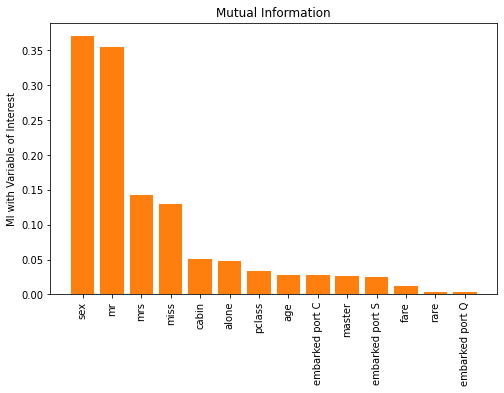

In [35]:
mi = {}
features = list(set(titanic.columns).difference(('survived',)))

for feature in features:
    mi[feature] = mutual_information(prob(titanic[['survived', feature]].values), 1)

plot_mi(mi)

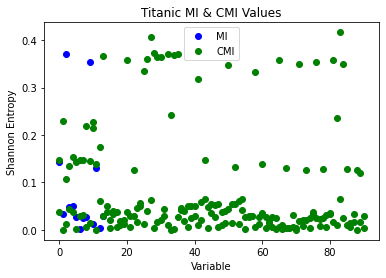

In [36]:
plt.plot(range(len(features)), [mutual_information(prob(titanic[['survived', feature]].values), 1) for feature in features], 'bo')

plt.plot(range(len([x for x in itertools.combinations(features, 2)])), [conditional_mutual_information(prob(titanic[['survived', f0, f1]].values), 1, 2) for f0, f1 in itertools.combinations(features, 2)], 'go')
plt.plot(range(len([x for x in itertools.combinations(features, 2)])), [conditional_mutual_information(prob(titanic[['survived', f1, f0]].values), 1, 2) for f0, f1 in itertools.combinations(features, 2)], 'go')

plt.title("Titanic MI & CMI Values")
plt.ylabel("Shannon Entropy")
plt.xlabel("Variable")
plt.legend(["MI", "CMI"])

## Building the MI-Based BQM
Select 8 features with the top MI ranking found above. 

In [37]:
keep = 8

sorted_mi = sorted(mi.items(), key=lambda pair: pair[1], reverse=True)
titanic = titanic[[column[0] for column in sorted_mi[0:keep]] + ["survived"]]
features = list(set(titanic.columns).difference(('survived',)))

print("Submitting for {} features: {}".format(keep, features))

Submitting for 8 features: ['mrs', 'pclass', 'sex', 'alone', 'cabin', 'mr', 'miss', 'age']


Calculate a BQM based on the problem's MI and CMI as done previously for the toy problem.

In [38]:
# !pip install dimod

In [39]:
import dimod

In [40]:
def plot_bqm(bqm):
    """Plot binary quadratic model as a labeled graph."""
    g = nx.Graph()
    g.add_nodes_from(bqm.variables)
    g.add_edges_from(bqm.quadratic)

    plt.figure(figsize=(8, 8))
    ax = plt.gca()
    ax.set_title(f"BQM with {len(bqm)} nodes and {len(bqm.quadratic)} edges")
    nx.draw_circular(g, with_labels=True, node_size=3000, node_color="y")
    plt.show()

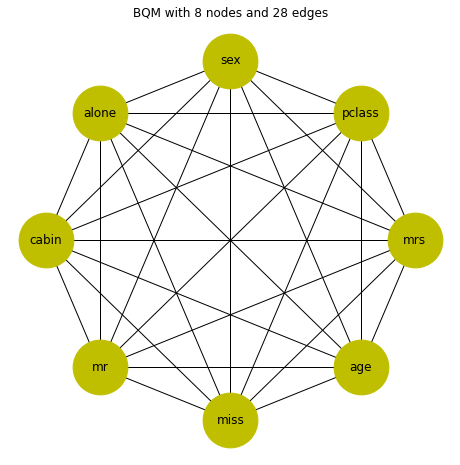

In [41]:
bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

# add the features
for feature in features:
    mi = mutual_information(prob(titanic[['survived', feature]].values), 1)
    bqm.add_variable(feature, -mi)

for f0, f1 in itertools.combinations(features, 2):
    cmi_01 = conditional_mutual_information(prob(titanic[['survived', f0, f1]].values), 1, 2)
    cmi_10 = conditional_mutual_information(prob(titanic[['survived', f1, f0]].values), 1, 2)
    bqm.add_interaction(f0, f1, -cmi_01)
    bqm.add_interaction(f1, f0, -cmi_10)

bqm.normalize()  

plot_bqm(bqm)

## Setting Up a QPU as a Solver

In [56]:
from dwave.system import DWaveSampler, FixedEmbeddingComposite
from minorminer.busclique import find_clique_embedding

endpoint = 'https://cloud.dwavesys.com/sapi'
token = 'DEV-e721167c50001a6b6abafab7487f9f13c9277aa2'
solver = 'DW_2000Q_6'

# qpu = DWaveSampler()
qpu = DWaveSampler(endpoint=endpoint, token=token, solver=solver)

qpu_working_graph = qpu.to_networkx_graph()
embedding = find_clique_embedding(bqm.variables, qpu_working_graph)
num_qubits = sum(len(chain) for chain in embedding.values())

qpu_sampler = FixedEmbeddingComposite(qpu, embedding)

print("Maximum chain length for minor embedding is {}.".format(max(len(x) for x in embedding.values())))

Maximum chain length for minor embedding is 3.


This problem is small enough to be solved in its entirety on a D-Wave 2000Q QPU. For datasets with higher numbers of features, D-Wave Ocean's [dwave-hybrid](https://docs.ocean.dwavesys.com/en/stable/docs_hybrid/sdk_index.html) tool can be used to break the BQM into smaller pieces for serial submission to the QPU and/or parallel solution on classical resources. Here, an out-of-the-box hybrid sampler, [Kerberos](https://docs.ocean.dwavesys.com/en/stable/docs_hybrid/reference/reference.html) is used.    

In [43]:
from hybrid.reference.kerberos import KerberosSampler

kerberos_sampler = KerberosSampler() 

## Submit the Problem for All k Values

In [49]:
def plot_feature_selection(features, selected_features):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_axes([0.1, 0.3, .9, .7])
    ax.set_title("Best Feature Selection")
    ax.set_ylabel('Number of Selected Features')
    ax.set_xticks(np.arange(len(features)))
    ax.set_xticklabels(features, rotation=90)
    ax.set_yticks(np.arange(len(features)))
    ax.set_yticklabels(np.arange(1, len(features)+1))
    # Set a grid on minor ticks
    ax.set_xticks(np.arange(-0.5, len(features)), minor=True)
    ax.set_yticks(np.arange(-0.5, len(features)), minor=True)
    ax.grid(which='minor', color='black')
    ax.imshow(selected_features, cmap=colors.ListedColormap(['white', 'red']))

In [53]:
MAX_TIME = 500000   # limit single-problem submissions to 0.5 seconds
num_reads = 50
anneal_schedule = [[0.0, 0.0], [40.0, 0.4], [1040.0, 0.4], [1042, 1.0]]
estimated_runtime = qpu.solver.estimate_qpu_access_time(num_qubits,
   num_reads=num_reads, anneal_schedule=anneal_schedule)    
print("Estimate of {:.0f}us on {}".format(estimated_runtime, qpu.solver.name))  
# Estimate of 75005us on Advantage_system4.1

if estimated_runtime < MAX_TIME:
   qpu_sampler = FixedEmbeddingComposite(qpu, embedding).sample(bqm,
      num_reads=num_reads, anneal_schedule=anneal_schedule)

Estimate of 74584us on DW_2000Q_6


Submitting for k=1
Submitting for k=2
Submitting for k=3
Submitting for k=4
Submitting for k=5
Submitting for k=6
Submitting for k=7
Submitting for k=8


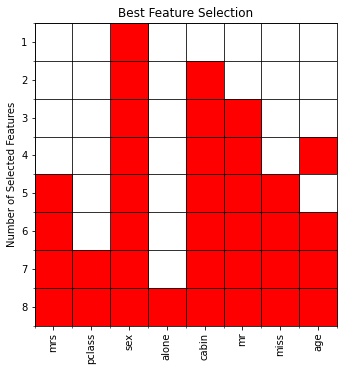

In [59]:
selected_features = np.zeros((len(features), len(features)))
for k in range(1, len(features) + 1):
    print("Submitting for k={}".format(k))
    kbqm = dimod.generators.combinations(features, k, strength=6)
    kbqm.update(bqm)
    kbqm.normalize()
    
    best = kerberos_sampler.sample(kbqm, 
                                   qpu_sampler=qpu_sampler, 
                                   qpu_reads=1000, 
                                   max_iter=1,
                                   qpu_params={'label': 'Notebook - Feature Selection'}
                                  ).first.sample
    
    for fi, f in enumerate(features):
        selected_features[k-1, fi] = best[f]

plot_feature_selection(features, selected_features)

# Reference:

1. [D-Wave Feature Selection example](https://green-kangaroo-0bqmh1vu.ws.ide.dwavesys.io/)